# ANN+Ensembling
In questo programma viene eseguita anomaly detection su un dataset di consumi elettrici riguardanti un'università olandese; nello specifico le anomalie vengono identificate nei giorni in cui i consumi sono significativamente diversi dal trend usuale.
Il modello predittivo utilizzato in questo caso è una combinazione di 10 reti neurali MLP, aventi medesima struttura, le quali vengo allenate con insiemi di dati leggermente diversi tra di loro. Successivamente, al momento della predizione, i risultati delle singole reti vengono combinati insieme usando un metodo di ensembling portando in output del modello la predizione definitiva. 

Come input per il modello predittivo si prende il campionamento dei consumi elettrici eseguito ogni 2 ore per un'intera settimana (7 giorni consecutivi) mentre come output si hanno i consumi, campionati ogni 2 ore anch'essi, della giornata successiva alla settimana presa in input. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import holidays
import datetime
import sklearn
from sklearn import neural_network
from sklearn import model_selection
import random
# %matplotlib notebook

In [2]:
plt.rcParams["figure.figsize"] = (16,8)
with open('power_data_eamonn-1.txt', 'r') as f:
    x = f.readlines()
#x
x = np.array([int(i) for i in x if i != '\n'])
print(len(x), x)
DAY = 96

35040 [950 939 943 ... 627 633 882]


Il dataset ha inizialmente una frequenza di campionamento pari a 1 lettura ogni 15 minuti. Di seguito si riduce il volume di esso diminuendo la frequenza di campionamento a 1 campione ogni 2 ore. La tecnica di compressione utilizzata è quella relativa alla media aritmetica: questa viene applicata alle 8 letture consecutive relative a una certa finestra temporale di 2 ore

In [3]:
mean_x = []
for ind in range(len(x)//8):
    val = 0
    for i in range(ind*8, ind*8+8):
        val += x[i]
    mean_x.append(val/8)
len(mean_x)   

4380

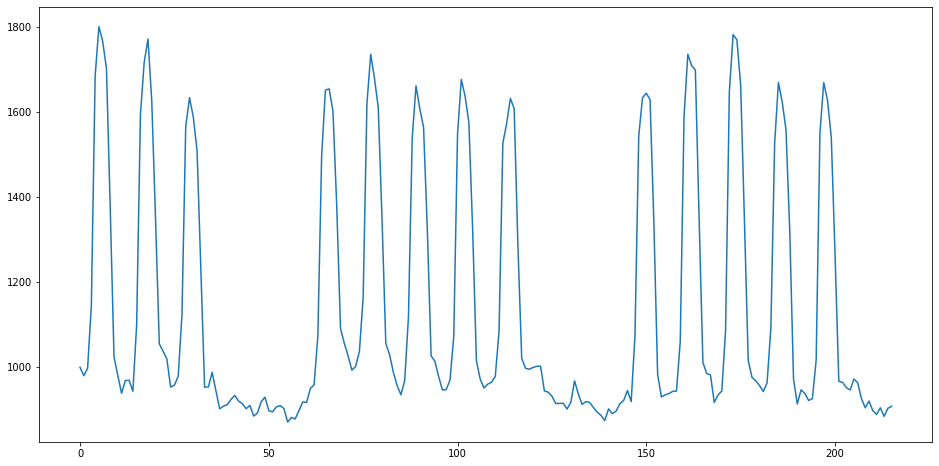

In [4]:
plt.plot(mean_x[1092:1308])
plt.show()

Ora vengono selezionate le porzioni di dataset necessarie all'allenamento del modello predittivo. La scelta di queste è stata fatta dopo una ricerca manuale di insiemi di dati privi di anomalie al loro interno; questo particolare, infatti, risulta cruciale per un buon funzionamento del modello predittivo riguardo il nostro obiettivo.

In [5]:
train = []
train.append(mean_x[60 : 1008])
train.append(mean_x[1704: 3204])
train.append(mean_x[3324: 4284])

Viene fatta una ricerca anche per i dati che verranno utilizzati come test per valutare il comportamento del modello predittivo. In questo caso si salvano gli indici del primo dato utile per la predizione di un certo giorno, ovvero il primo valore di consumo del primo giorno della settimana precedente al giorno in questione.
Il primo array contiene gli indici di alcune anomalie (identificate manualmente accertandosi che il valore da predirre fosse
anomalo e che, invece, la settimana precedente fosse completamente priva di anomalie), mentre il secondo contiene degli indici di giornate casuali dal comportamento nominali, le quali, tuttavia, non sono contenute nell'insieme dei dati usati per allenare il modello.

In [6]:
in_anomalies = [1572, 1344, 948]
in_othertest = [1128, 1140, 1152, 1164, 1176, 1188, 1200]

### Fase di train
In questa fase viene effettivamente creato il train set (dataset usato per allenare il modello predittivo). I valori relativi ai consumi registrati vengono normalizzati su una distribuzione uniforme nel range [0, 1]. Sul dataset prodotto la distanza temporale tra un dato e il successivo è di 1 giorno (12 valori sul dataset inziale).

In [7]:
max_power = max(mean_x)
min_power = min(mean_x)
delta_power = max_power - min_power
norm_x = []

norm_x.append([])
for record in train[0]:
    norm_x[-1].append((record-min_power)/delta_power)  
norm_x.append([])
for record in train[1]:
    norm_x[-1].append((record-min_power)/delta_power)
    
temp = []
y = []
for h in range(len(norm_x)):
    ind = 0
    while ind < len(norm_x[h])-12*8:
        new_row = []
        for i in range(12*7):
            new_row.append(norm_x[h][i+ind])
        temp.append(new_row)    
        new_row = []    
        for i in range(12):
            new_row.append(norm_x[h][ind+i+12*7])
        y.append(new_row)
        ind += 12   
        
X_train = pd.DataFrame(temp)
y_train = pd.DataFrame(y)
X_train

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0.272988,0.280494,0.287309,0.404642,0.790222,0.929185,0.924840,0.872494,0.680198,0.436543,...,0.250074,0.256198,0.262716,0.294716,0.253926,0.267457,0.275160,0.287605,0.267556,0.259556
1,0.350025,0.326222,0.364938,0.477235,0.896099,0.934025,0.904296,0.866469,0.605136,0.351407,...,0.279407,0.359111,0.796840,0.941630,0.916642,0.865481,0.610864,0.353580,0.291556,0.283160
2,0.283160,0.287407,0.290173,0.387457,0.822617,0.886321,0.850568,0.814617,0.639407,0.362765,...,0.278025,0.409086,0.851062,0.891852,0.861333,0.820840,0.581037,0.361284,0.318025,0.293432
3,0.272395,0.284247,0.295901,0.416099,0.852247,0.954667,0.976691,0.939457,0.653827,0.438914,...,0.273481,0.371160,0.831802,0.943901,0.876543,0.858272,0.640099,0.412840,0.332346,0.337284
4,0.323556,0.305481,0.296691,0.408099,0.831704,0.896889,0.921185,0.846321,0.591802,0.354568,...,0.281284,0.402469,0.858864,0.939654,0.899753,0.860247,0.602370,0.369284,0.336296,0.305975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,0.234864,0.265778,0.284148,0.386765,0.742025,0.797235,0.662716,0.697778,0.502222,0.309630,...,0.230025,0.362765,0.712099,0.752198,0.789333,0.774617,0.579852,0.356840,0.290963,0.280889
184,0.297580,0.265086,0.263704,0.271407,0.276938,0.274469,0.266272,0.270420,0.263407,0.231012,...,0.245037,0.340543,0.786074,0.859951,0.788741,0.703407,0.436642,0.308938,0.283852,0.262222
185,0.197235,0.196938,0.200198,0.183605,0.187457,0.187160,0.192691,0.178568,0.171457,0.177481,...,0.200593,0.148346,0.239111,0.208988,0.215605,0.163654,0.200395,0.196148,0.193679,0.198025
186,0.187259,0.196444,0.248691,0.262123,0.697877,0.727704,0.793086,0.762272,0.558914,0.369284,...,0.159012,0.178667,0.205728,0.174222,0.175605,0.176099,0.168296,0.176099,0.194667,0.187556


Si procede ora con l'allenamento dei 10 modelli MLP. Essi vengono allenati con insiemi di dati leggermente diversi gli uni dagli altri (altrimenti avrebbero tutti il medesimo comportamento). Nello specifico il volume di dati che effettivamente viene usato per allenare i singoli modelli è pari al 80% del train set iniziale. 
Tutte le reti neurali utilizzate sono composte al loro interno da 3 layer composti a loro volta da 40 neuroni ognuno, la funzione di attivazione utilizzata su questi neuroni è la tangente iperbolica e il valore massimo di iterazioni eseguibili è impostato a 1000.

In [8]:
in_line = []
for i in X_train.index.values:
    in_line.append(i)
regressors = []
for i in range(10):
    random.shuffle(in_line)
    Xi_train = []
    yi_train = []
    for line in range(int(len(in_line)*0.8)):
        Xi_train.append(X_train.loc[in_line[line]])
        yi_train.append(y_train.loc[in_line[line]])
    model = neural_network.MLPRegressor(hidden_layer_sizes = (40, 40, 40), activation = 'tanh', max_iter = 1000).fit(Xi_train, yi_train)
    regressors.append(model)

### Fase di test
Il medesimo procedimento per la composizione del train set viene eseguito per la realizzazione del test set, anch'esso normalizzando i dati come fatto in precedenza.
Per come è realizzato il codice, il test set avrà come primi 3 dati delle anomalie mentre tutti i dati successivi saranno giorni con un comportamento nominale.

In [9]:
X_test = []
y_test = []

test = in_anomalies+in_othertest
for ind in test:
    new_row = []
    for i in range(ind, ind+7*12):
        new_row.append((mean_x[i]-min_power)/delta_power)
    X_test.append(new_row)
    new_row = []
    for i in range(ind+7*12, ind+8*12):
        new_row.append((mean_x[i]-min_power)/delta_power)
    y_test.append(new_row)    
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

Ora si vanno a registrare i valori predetti dai modelli allenati in precedenza sui dati del test set. Essi sono ottenuti eseguendo una tecnica di ensembling (in questo caso si utilizza la media aritmetica) tra i 10 risultati riguardanti il medesimo input.

In [10]:
predicted = []
for i in range(10):
    prediction = regressors[i].predict(X_test)
    predicted.append(prediction)
    
predicted_mean = []
for i in range(len(y_test)):
    prediction = []
    for j in range(12):
        prediction.append(0)
    for j in range(10):
        for h in range(12):
            prediction[h] += predicted[j][i][h]/10
    predicted_mean.append(prediction)
predicted = pd.DataFrame(predicted_mean)  
predicted

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.213694,0.233378,0.233353,0.252191,0.566151,0.639900,0.605449,0.573922,0.472895,0.274535,0.252127,0.269260
1,0.264994,0.293571,0.267810,0.369693,0.686150,0.818027,0.733149,0.747054,0.537695,0.320250,0.253712,0.266242
2,0.278802,0.272768,0.252180,0.331976,0.622062,0.672735,0.632614,0.607764,0.452663,0.312902,0.266782,0.286162
3,0.256093,0.250686,0.251458,0.223729,0.317920,0.306067,0.291140,0.274688,0.262944,0.228491,0.272762,0.226473
4,0.223759,0.236065,0.229740,0.180378,0.288309,0.295434,0.305622,0.259199,0.297510,0.203513,0.247085,0.237814
5,0.209821,0.224801,0.233242,0.290778,0.614756,0.700582,0.666775,0.641448,0.504764,0.293926,0.253813,0.285939
6,0.259707,0.273945,0.269801,0.376148,0.740817,0.866302,0.807193,0.787488,0.568960,0.339571,0.283013,0.266333
7,0.280822,0.301632,0.274800,0.373063,0.692041,0.819918,0.730812,0.740503,0.545732,0.321821,0.263248,0.273541
8,0.256334,0.288491,0.247444,0.361543,0.701387,0.829720,0.797902,0.735635,0.535970,0.301312,0.239627,0.274931
9,0.252967,0.271377,0.231515,0.325903,0.609487,0.659159,0.642358,0.602793,0.435728,0.294779,0.262193,0.263747


Di seguito vengono stampati i risultati ottenuti sul test set mettendo a confronto i valori predetti con i valori reali.

Giorno anomalo


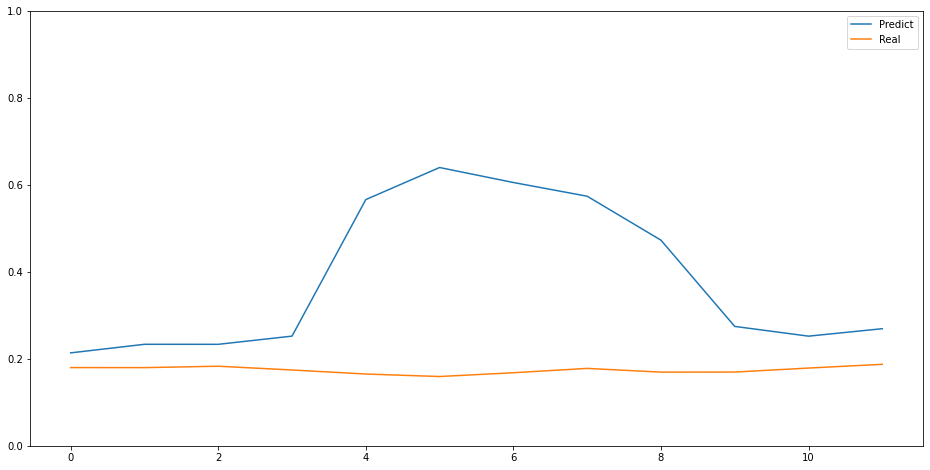

Giorno anomalo


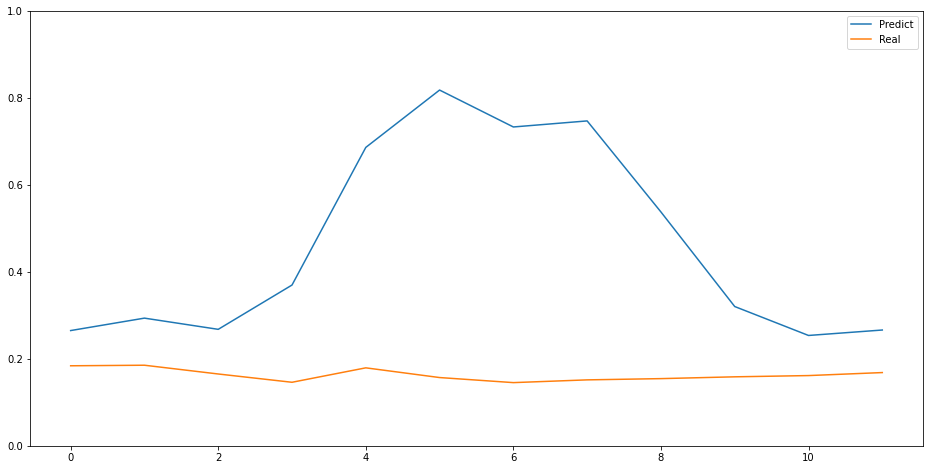

Giorno anomalo


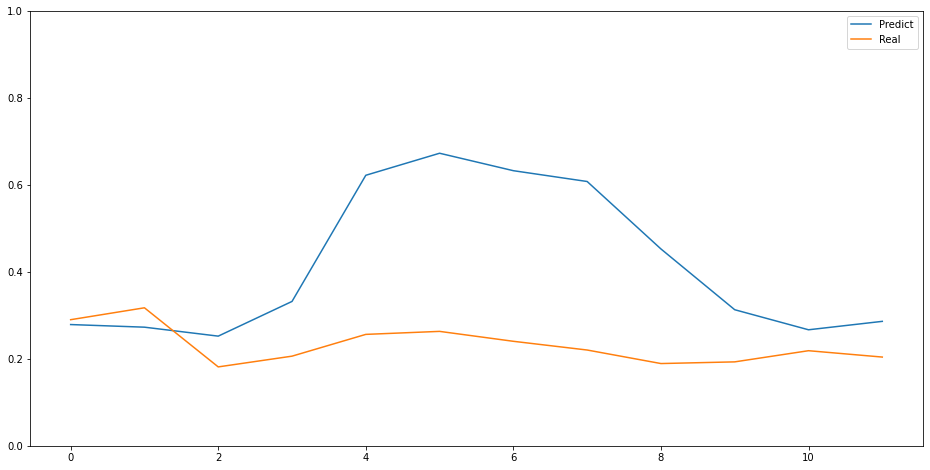

Giorno non anomalo


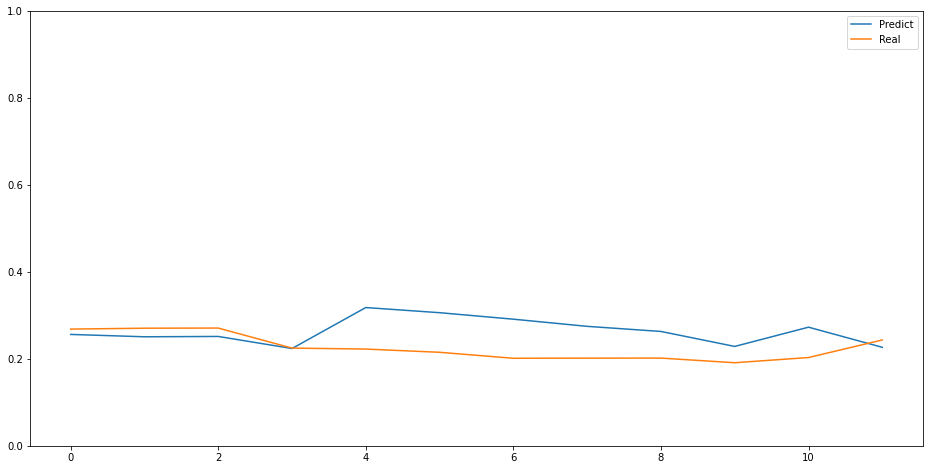

Giorno non anomalo


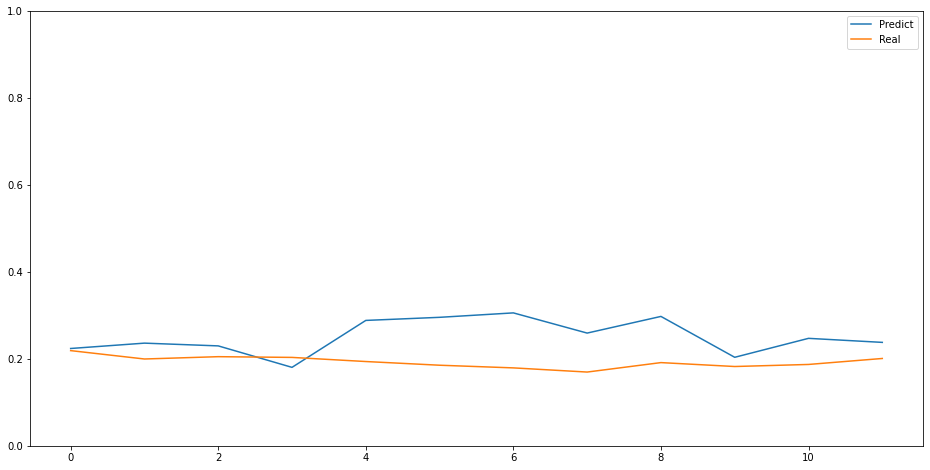

Giorno non anomalo


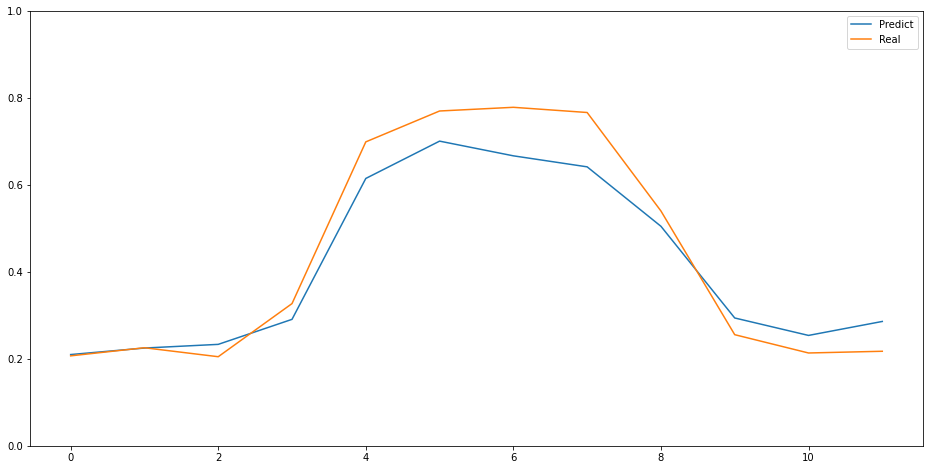

Giorno non anomalo


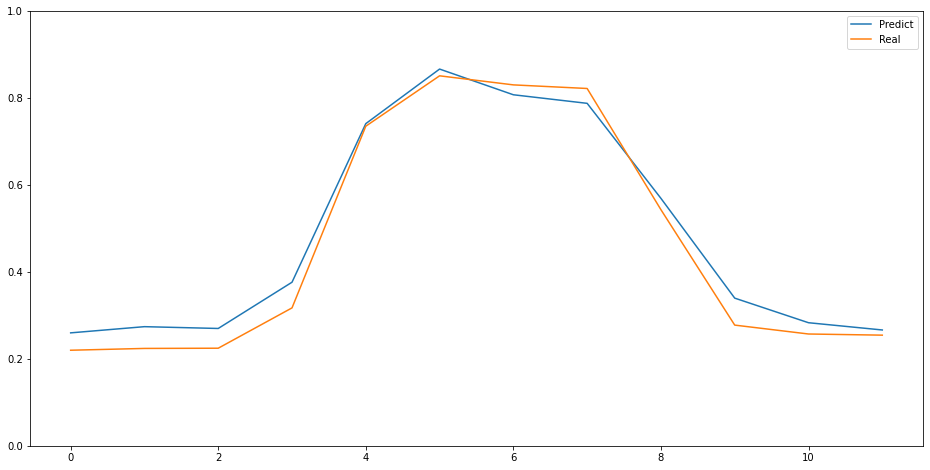

Giorno non anomalo


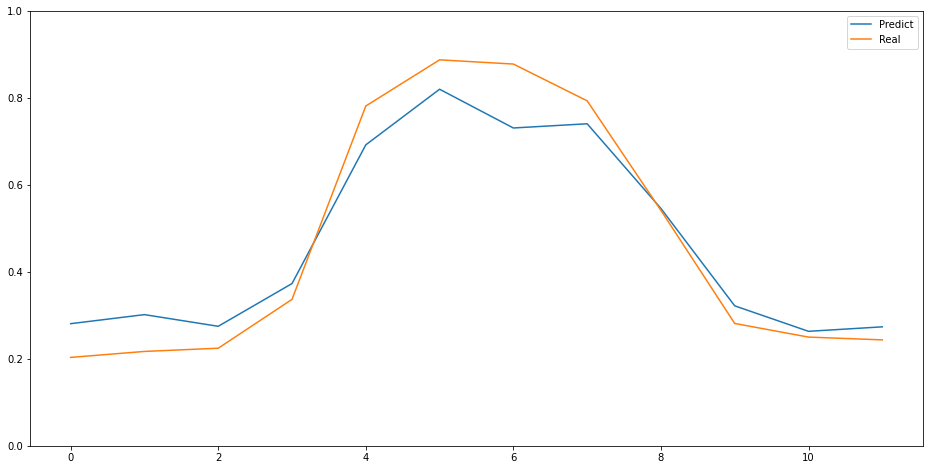

Giorno non anomalo


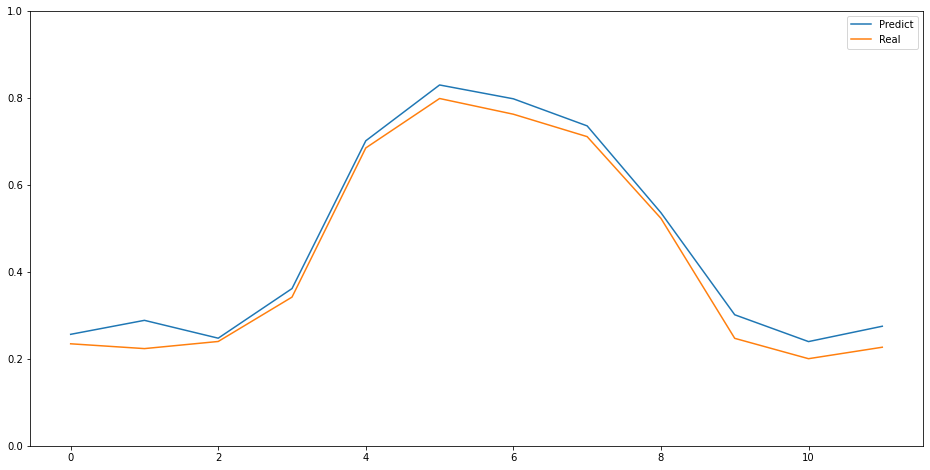

Giorno non anomalo


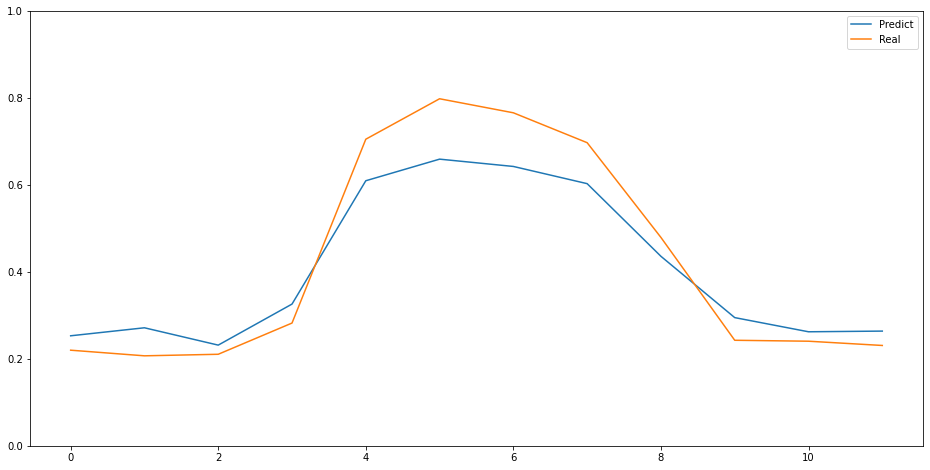

In [13]:
for i, sample in predicted.iterrows():
    if i < 3:
        print("Giorno anomalo")
    else:
        print("Giorno non anomalo")
    plt.plot(predicted.columns, predicted.loc[i], label='Predict')
    plt.plot(y_test.columns, y_test.loc[i], label='Real')
    plt.ylim((0,1))
    plt.legend()
    plt.show()

I risultati ottenuti sono positivi dal momento che si nota una buona ricostruzione dei giorni non anomali, il trend di questi infatti viene riconosciuto sia nel caso di giorni lavorativi (dal lunedì al venerdì) sia nel caso di giorni festivi (durante il fine settimana). Per quel che riguarda i giorni anomali, il modello si comporta bene dato che riconosce i consumi tipici di un giorno lavorativo, facendo riferimento ai primi 3 test stampati in precedenza, quando i consumi reali invece hanno un trend attribuibile a una giornata non lavorativa. In questo modo la somma delle differenze tra i valori predetti e i valori reali genera un errore significativo con il quale si è grado di identificare i giorni anomali. Visti i risultati ottenuti è presumibile che il metodo utilizzato sia efficace anche nella identificazione di giorni anomali con consumi bassi nel trend usuale ma che nella realtà presentano consumi attribuibili a giorni lavorativi.